In [1]:
!apt-get install aria2 > /dev/null

In [2]:
!aria2c -x 16 -s 16 https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip > /dev/null 
!aria2c -x 16 -s 16 https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip > /dev/null

In [3]:
!unzip /content/Flickr8k_Dataset.zip > /dev/null
!unzip /content/Flickr8k_text.zip > /dev/null
!rm *.zip > /dev/null

In [1]:
import re
import collections
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm_notebook as tqdm

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
def clean_description(desc, stopwords):

  cleaned = desc.lower()
  cleaned = re.sub('[^a-z]',' ',cleaned)
  tokens = cleaned.split(' ')
  cleaned = ' '.join([w for w in tokens if w not in stopwords and len(w)>1])
  
  return cleaned

In [3]:
def get_vocabulary(dictionary):
  vocab = set()

  for desc_list in dictionary.values():
    for desc in desc_list:
      words = desc.split(' ')
      for word in words:
        vocab.add(word)

  return vocab

In [4]:
with open('/content/Flickr8k.token.txt', 'r') as f:
  all_desc = f.read().split('\n')

In [5]:
# Some sample data
all_desc[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [6]:
stopwords = ['is', 'an', 'a', 'the', 'was']

In [10]:
all_dict = dict()

for desc in all_desc:
  if len(desc) < 1:
    continue
  file_name, file_desc = desc.split('\t')[0].split('.')[0], desc.split('\t')[1]
  
  if file_name not in all_dict.keys():
    all_dict[file_name] = []

  cleaned_desc = clean_description(file_desc, stopwords)
  cleaned_desc = 'startseq ' + cleaned_desc + ' endseq'

  all_dict[file_name].append(cleaned_desc)

In [11]:
vocab = get_vocabulary(all_dict)

In [12]:
print('Total images:', len(all_dict))
print('Total vocabulary without stopwords:', len(vocab))

Total images: 8092
Total vocabulary without stopwords: 8423


In [ ]:
!wget https://banner2.cleanpng.com/20181128/vpu/kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg > /dev/null

In [14]:
mask = np.array(Image.open('kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg'))

wordcloud = WordCloud(width = 500, height = 400, 
                  background_color ='black', 
                  min_font_size = 10,
                  mask=mask, random_state=0).generate(' '.join(vocab)) 

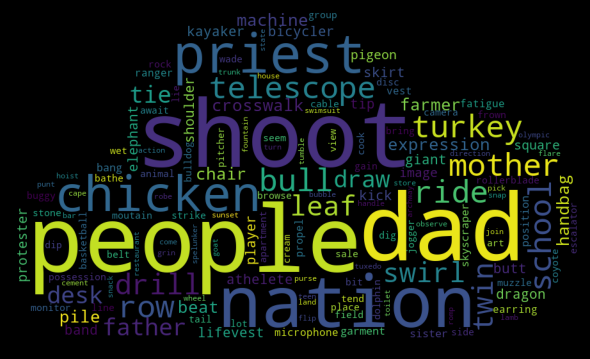

In [15]:
plt.figure(figsize = (8, 8), facecolor = 'k', edgecolor = 'k' ) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [16]:
all_sent_list = [item.strip('startseq').strip('endseq').strip(' ') for sublist in list(all_dict.values()) for item in sublist]

In [17]:
all_sent_len = [len(sent) for sent in all_sent_list]

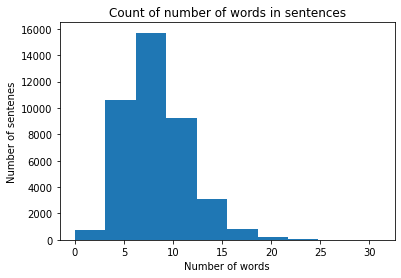

In [18]:
plt.hist([len(sentence.split()) for sentence in all_sent_list])
plt.xlabel('Number of words')
plt.ylabel('Number of sentenes')
plt.title('Count of number of words in sentences')
plt.show()

In [19]:
avg_sent_len = int(np.mean([len(sentence.split()) for sentence in all_sent_list]))
avg_sent_len

8

In [20]:
words = [w for a in all_sent_list for w in a.split(' ')]

In [21]:
counts = collections.Counter(words)
most_common = counts.most_common()
most_common[:15]

[('in', 18987),
 ('on', 10746),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176)]

In [22]:
keys = [tupl[0] for tupl in most_common][:15]
values = [tupl[1] for tupl in most_common][:15]

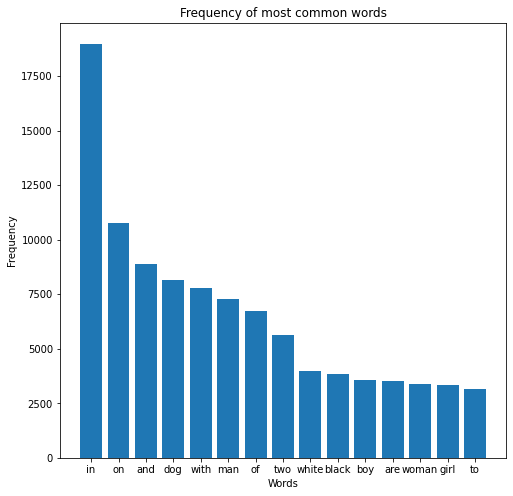

In [23]:
plt.figure(figsize=(8, 8))
plt.bar(keys, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of most common words')
plt.show()